In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок


# Выбираем их явно, чтобы список был перед глазами, и отложилось в голове, что имена писателей (точнее их порядковый номер) - это метки
CLASS_LIST=['Blok', 'Lermontov', 'Nekrasov', 'Pushkin', 'Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Gorky', 'Herzen', 'Tolstoy', 'Turgenev']

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('/content/drive/MyDrive/poets/poems/{}/*.txt'.format(author)) +  glob.glob('/content/drive/MyDrive/poets/prose/{}/*.txt'.format(author)) +  glob.glob('/content/drive/MyDrive/poets/publicism/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом


In [ ]:
# Создаем новый список с писателями у которых наибольший объем текста
total = sorted([len(i) for i in all_texts.values()], reverse = True)[:4]
CLASS_LIST_NEW = []
for author in CLASS_LIST:
  for j in total:
    if len(all_texts[author]) == j:
      CLASS_LIST_NEW.append(author)
print(f'Писатели с большими объемами текста: {CLASS_LIST_NEW}')

# Авторы которых необходимо удалить
del_author = [x for x in CLASS_LIST if x not in CLASS_LIST_NEW]

# Удаление авторов из словаря all_texts
for author in del_author:
    all_texts.pop(author, None)

print(all_texts.keys())

Писатели с большими объемами текста: ['Bryusov', 'Dostoevsky', 'Gorky', 'Tolstoy']
dict_keys(['Bryusov', 'Dostoevsky', 'Gorky', 'Tolstoy'])


In [ ]:
from keras.preprocessing.text import Tokenizer

embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST_NEW:
    cls = CLASS_LIST_NEW.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))


median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST_NEW:
    cls = CLASS_LIST_NEW.index(author)
    if len(seq_train[cls]) > median * 0.6:
      seq_train_balance.append(seq_train[cls][:median])
      CLASS_LIST_BALANCE.append(author)

Датасет состоит из 3779489 слов
Общая выборка по писателям (по словам):
Bryusov - 350743 слов, доля в общей базе: 9.28%
Dostoevsky - 1553143 слов, доля в общей базе: 41.09%
Gorky - 554413 слов, доля в общей базе: 14.67%
Tolstoy - 1321190 слов, доля в общей базе: 34.96%
Среднее значение слов:  944872.0
Медианное значение слов:  937801.5


In [ ]:
seq_train_balance = [seq_train[cls][:350000] for cls in range(len(CLASS_LIST_NEW))]

# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 1400000 слов


Общая выборка по писателям (по словам):
Bryusov - 350000 слов, доля в общей базе: 25.00%
Dostoevsky - 350000 слов, доля в общей базе: 25.00%
Gorky - 350000 слов, доля в общей базе: 25.00%
Tolstoy - 350000 слов, доля в общей базе: 25.00%
Среднее значение слов:  350000.0
Медианное значение слов:  350000.0


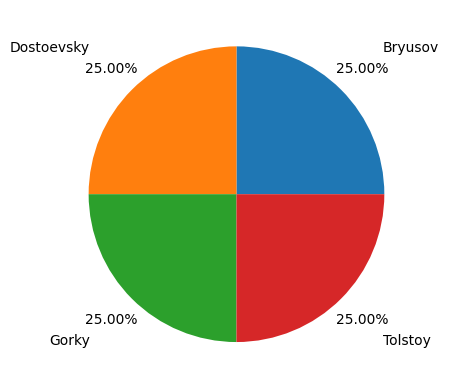

In [ ]:
import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST_NEW:
    cls = CLASS_LIST_NEW.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_NEW,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
from keras.utils import get_file, to_categorical

WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    val_split,  # Доля на проверочную выборку
    test_split, # Доля на тестовую выборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_val, y_val, x_test, y_test =  [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        cls = class_list.index(class_item)
        gate_val = int(len(seq_list[cls]) * (1 - val_split - test_split))
        gate_test = int(len(seq_list[cls]) * (1 - test_split))

        vectors_train = seq_split(seq_list[cls][:gate_val], win_size, step)
        vectors_val = seq_split(seq_list[cls][gate_val:gate_test], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_test:], win_size, step)

        x_train += vectors_train
        x_val += vectors_val
        x_test += vectors_test

        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_val += [to_categorical(cls, len(class_list))] * len(vectors_val)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)

    return (
        np.array(x_train), np.array(y_train),
        np.array(x_val), np.array(y_val),
        np.array(x_test), np.array(y_test)
    )

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, 0.1, CLASS_LIST_NEW, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')
print(f'Форма входных данных для проверочной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для проверочной выборки: {y_val.shape}')
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для обучающей выборки: (11164, 1000)
Форма выходных данных (меток) для обучающей выборки: (11164, 4)
Форма входных данных для проверочной выборки: (1364, 1000)
Форма выходных данных (меток) для проверочной выборки: (1364, 4)
Форма входных данных для тестовой выборки: (1364, 1000)
Форма выходных данных (меток) для тестовой выборки: (1364, 4)


In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели: '+title)
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

--2024-04-14 08:31:36--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.2MB/s    in 3.1s    

2024-04-14 08:31:40 (16.2 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

In [ ]:
from keras.layers import Embedding, Dense, SpatialDropout1D, BatchNormalization, Dropout
from keras.layers import GRU, LSTM, Bidirectional

model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(16, return_sequences=True, reset_after=True))
model_MIX.add(GRU(16, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(100, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST_NEW), activation='softmax'))

In [ ]:
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mix = model_MIX.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/10
349/349 [==============================] - 1261s 4s/step - loss: 1.5157 - accuracy: 0.3336 - val_loss: 1.1650 - val_accuracy: 0.4934
Epoch 2/10
349/349 [==============================] - 1213s 3s/step - loss: 0.7687 - accuracy: 0.7114 - val_loss: 2.1758 - val_accuracy: 0.3387
Epoch 3/10
349/349 [==============================] - 1197s 3s/step - loss: 0.3850 - accuracy: 0.8786 - val_loss: 0.6070 - val_accuracy: 0.8556
Epoch 4/10
349/349 [==============================] - 1209s 3s/step - loss: 0.1583 - accuracy: 0.9604 - val_loss: 1.0985 - val_accuracy: 0.7434
Epoch 5/10
349/349 [==============================] - 1192s 3s/step - loss: 0.0808 - accuracy: 0.9798 - val_loss: 0.2959 - val_accuracy: 0.9348
Epoch 6/10
349/349 [==============================] - 1219s 3s/step - loss: 0.0261 - accuracy: 0.9949 - val_loss: 0.2412 - val_accuracy: 0.9457
Epoch 7/10
349/349 [==============================] - 1205s 3s/step - loss: 0.0179 - accuracy: 0.9970 - val_loss: 0.1284 - val_accuracy:

In [ ]:
model_MIX.save('model_poets.keras')

In [ ]:
# После обучения, оцените производительность модели на тестовой выборке
test_loss, test_accuracy = model_MIX.evaluate(x_test, y_test)
print("Точность на тестовой выборке:", test_accuracy)
print("Потери на тестовой выборке:", test_loss)

43/43 [==============================] - 22s 520ms/step - loss: 0.4567 - accuracy: 0.9150
Точность на тестовой выборке: 0.9149560332298279
Потери на тестовой выборке: 0.45668303966522217


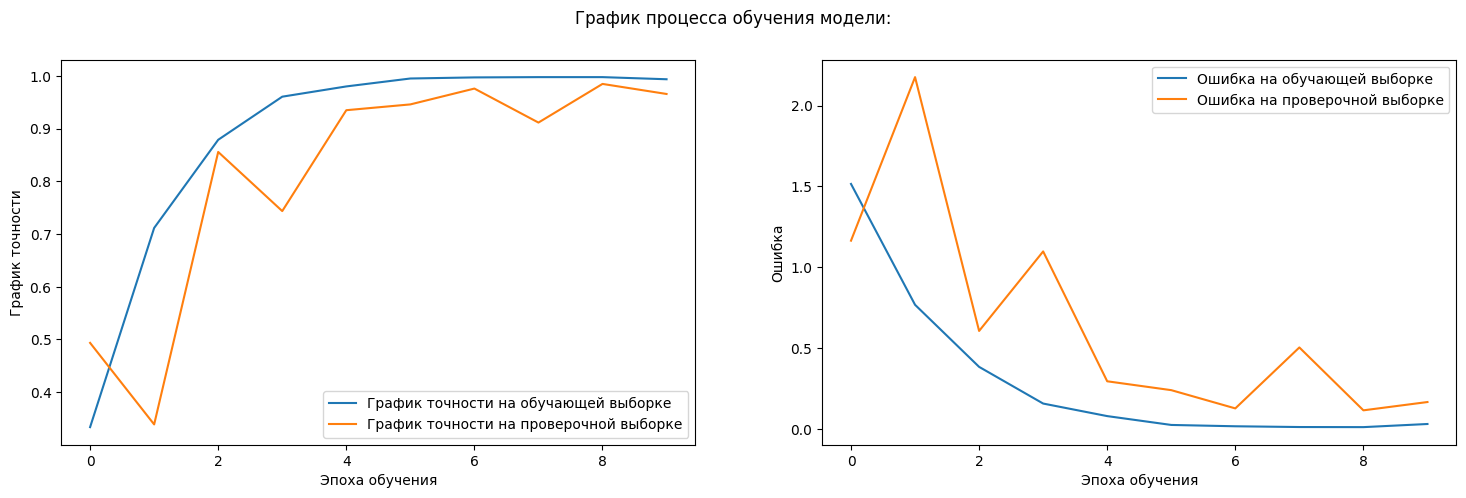

In [ ]:
show_plot(history_mix)

43/43 [==============================] - 26s 517ms/step


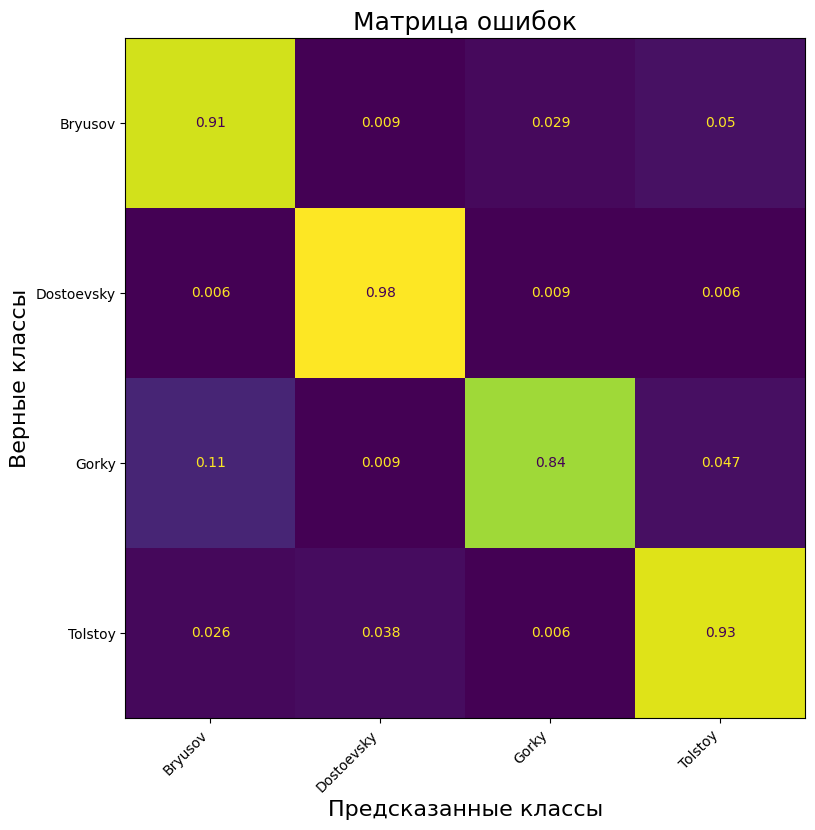


Средняя точность распознавания:  92%


In [ ]:
y_pred_mix = model_MIX.predict(x_test)
show_confusion_matrix(y_test, y_pred_mix, CLASS_LIST_NEW)

Стихотворение от жены

Здравствуй, пап!

Я сегодня в шапке

И за дверью ее не сниму.

Как ты там?

Как дела у мамы?

Скоро буду и вас обниму!

Вот приеду и, будто в детстве,

Прошмыгну под твое крыло.

В мире, полном несоответствий,

Только дома всегда тепло.

Ты такой же, как и когда-то:

Тот же запах и тот же взгляд,

Приготовил макароны по-флотски

И вскопал уж семь грядок подряд…

Пусть волос уж коснулась проседь,

Ты не станешь ее скрывать.

Пусть тебе будет тридцать шесть лет,

Ну, а мне на день снова пять.

Я скучала, я так скучала,

Наши встречи в душе храня,

Мне всегда тебя будет мало,

А тебе не хватать меня!

Мало споров и разговоров,

Мало встреч, чтоб тебя обнять.

Подожди… я приеду скоро,

Чтобы мне снова было пять…


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Предобработка текста
test_text = open('/content/drive/MyDrive/poets/стих.txt', 'r').read()
test_sequence = tokenizer.texts_to_sequences([test_text])
test_padded_sequence = pad_sequences(test_sequence, maxlen=WIN_SIZE)

# Предсказание с помощью обученной модели
predicted_probabilities = model_MIX.predict(test_padded_sequence)
predicted_class_index = np.argmax(predicted_probabilities)
predicted_poet = CLASS_LIST_NEW[predicted_class_index]

print("Предполагаемый поэт:", predicted_poet)


1/1 [==============================] - 10s 10s/step
Предполагаемый поэт: Gorky
